In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template, Gating
from tqdm import tqdm_notebook, tqdm
from functools import partial
import warnings
warnings.filterwarnings('ignore')
global_init()
iltis = Project.objects(project_id='ILTIS').get()
t1_exp = iltis.load_experiment('t1_exp')

In [2]:
all_results = pd.read_csv('experiment_data/auto_results.csv')

In [3]:
all_results = all_results.drop_duplicates()[['pt_id', 'name', 'parent', 'prop_of_parent', 'prop_of_total', 'count']]

In [4]:
manual = pd.read_excel('experiment_data/sepsis all FACS data 180812.xlsx')

In [5]:
manual = manual[manual['day'] == 1]

In [6]:
manual['patient ID'] = manual['patient ID'].apply(lambda x: x.replace('-00', '').replace('-0', ''))

In [7]:
manual = manual.rename(columns={'patient ID':  'pt_id'})

In [8]:
manual = manual[manual.pt_id != 'sep38']

In [9]:
manual

,pt_id,day,date,mixed data from T and T2 panels for cell counts and %,%lympho from total,count lympho,% live T cells from total,% live Tcells from lympho,count live T cells,% nonGD T cells from live T cells,...,SD MFI CD40 Mnc CD14-CD16+,MFI CD62L Mnc CD14-CD16+,SD MFI CD62L Mnc CD14-CD16+,%CD86+ Mnc CD14-CD16+,%CD64+ Mnc CD14-CD16+,%CD11b+ Mnc CD14-CD16+,%HLA-DR+ Mnc CD14-CD16+,%CD40+ Mnc CD14-CD16+,%CD62L+ Mnc CD14-CD16+,Colonne4
0,sep6,1,2018-01-28,done,0.1655,338418,0.0996,0.6175,204713,0.985,...,1058,485,327,97.8 %,62.7 %,95.8 %,97.6 %,98.9 %,43.0 %,NaN
2,sep12,1,2018-02-22,done,0.04605,167304,0.00915,0.2055,33203,0.984,...,2571,912,1145,25.6 %,25.9 %,97.1 %,27.6 %,36.6 %,66.3 %,NaN
4,sep13,1,2018-02-22,done,0.125,167614,0.0403,0.3315,53790,0.9365,...,3476,1268,1894,39.8 %,27.5 %,97.7 %,42.7 %,52.6 %,80.1 %,NaN
6,sep17,1,2018-03-23,done,0.1665,1349000,0.0433,0.3075,348126,0.995,...,1850,517,310,82.4 %,42.9 %,97.7 %,96.8 %,97.8 %,49.4 %,NaN
8,sep19,1,2018-03-26,done,0.1665,674500,0.0433,0.3075,174063,0.995,...,354,405,265,0.85 %,3.42 %,100 %,69.2 %,35.0 %,28.2 %,NaN
10,sep28,1,2018-04-05,done,0.396,382253,0.24,0.626,231979,0.987,...,3841,1123,1427,83.9 %,7.40 %,89.6 %,89.1 %,97.0 %,69.8 %,NaN
12,sep29,1,2018-04-19,done,0.557,486187,0.4155,0.7435,378890,0.97,...,1589,426,303,82.3 %,16.6 %,99.4 %,92.0 %,85.9 %,31.5 %,NaN
14,sep34,1,2018-04-27,done,0.118,427911,0.07855,0.6775,286086,0.9985,...,1355,1082,897,73.8 %,51.5 %,87.5 %,89.1 %,91.5 %,78.5 %,NaN
16,sep37,1,2018-04-28,done,0.493,991000,0.1485,0.3055,298828,0.994,...,4315,766,618,94.4 %,93.5 %,97.2 %,95.5 %,98.2 %,62.8 %,NaN
20,sep49,1,2018-07-04,done,0.4975,544748,0.334,0.6785,365511,0.9935,...,4124,1151,1322,79.7 %,88.9 %,97.6 %,92.3 %,88.5 %,74.6 %,NaN


In [28]:
manual_ross = pd.read_csv('experiment_data/manual_gates.csv')

In [29]:
manual_ross

,pt_id,Lymphocytes | Count,Lymphocytes/Single Cells | Count,Lymphocytes/Single Cells/Single Cells | Count,Lymphocytes/Single Cells/Single Cells/Live | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/GDTs | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD4 | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD8 | Count,Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/MAITs | Count,Count
0,sep6,185459,182978,182325,169171,93521,1137,91985,89901,84438,2945,1508,1000000
1,sep12,77842,75951,75650,63094,16124,229,15706,15556,6941,8371,82,1820000
2,sep13,108958,104791,102787,97995,26515,1571,24498,23256,15764,7189,1004,699000
3,sep49,279868,273388,273051,251144,180963,340,162624,158976,89693,64109,3312,579000
4,sep50,265036,254840,253975,187067,160678,852,150010,149665,135536,13106,204,1450000
5,sep51,401000,395187,394215,368693,321341,1152,318071,316967,250338,59930,644,736000
6,sep61,343608,296424,289509,240116,224238,10727,211389,200448,124068,54860,10146,3810000
7,sep67,230560,195427,192044,181290,128030,299,124182,123575,118496,4428,478,1330000
8,sep68,405000,380165,377790,347857,218960,5434,213012,208433,190752,14734,3873,911000
9,sep17,679000,647000,642000,575000,179111,697,165696,164959,141557,21555,666,3460000


In [13]:
counts = all_results.pivot(index='pt_id', values='count', columns='name').reset_index()

In [15]:
manual_ross.columns

Index(['pt_id', 'Lymphocytes | Count', 'Lymphocytes/Single Cells | Count',
       'Lymphocytes/Single Cells/Single Cells | Count',
       'Lymphocytes/Single Cells/Single Cells/Live | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/GDTs | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD4 | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD8 | Count',
       'Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/MAITs | Count'],
      dtype='object')

<h3>Live T cells</h3>

In [83]:
def comparison_plots(auto_population, auto_parent, manual_population, manual_parent, 
                     l_manual_col_name, ylabel):
    c = counts.copy()
    mr = manual_ross.copy()
    m = manual[['pt_id', l_manual_col_name]]
    
    c['Automated'] = c[auto_population]/c[auto_parent]
    c = c[['pt_id', 'Automated']]
    
    mr['Manual 1'] = mr[manual_population]/mr[manual_parent]
    mr = mr[['pt_id', 'Manual 1']]
    
    m['Manual 2'] = m[l_manual_col_name]
    
    d = pd.merge(pd.merge(c, m, on='pt_id'), mr, on='pt_id')
    ds = d[['Automated', 'Manual 1', 'Manual 2']].melt(var_name='Method', value_name=ylabel)
    sns.swarmplot(data=ds, x='Method', y=ylabel, color=".2")
    plt.show()
    d = d[['pt_id', 'Manual 1', 'Manual 2', 'Automated']].set_index('pt_id')
    fig, ax = plt.subplots(figsize=(5,6)) 
    sns.heatmap(d[d.columns].astype(float).sort_values('Automated'), 
                annot=True, ax=ax, linewidths=2, cmap="GnBu")
    ax.set_ylim(15.0,0.0)
    plt.show()

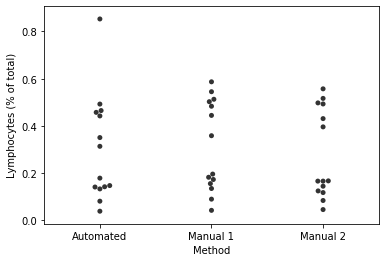

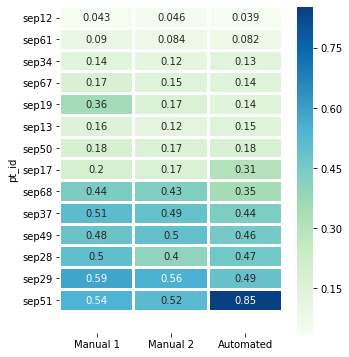

In [84]:
comparison_plots(auto_population='lymphocytes', 
                 auto_parent='root', 
                 l_manual_col_name='%lympho from total', 
                 ylabel='Lymphocytes (% of total)',
                 manual_population='Lymphocytes | Count',
                 manual_parent='Count')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2a140d400>)

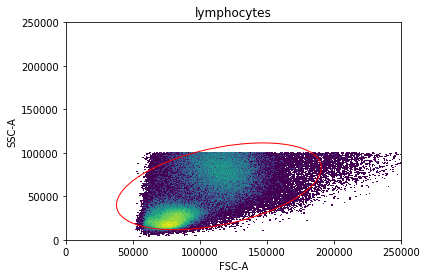

In [85]:
t_template = Template(experiment=t1_exp, sample_id='sep51')
t_template.plot_gate('lymphocytes')

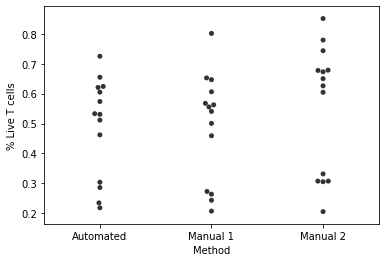

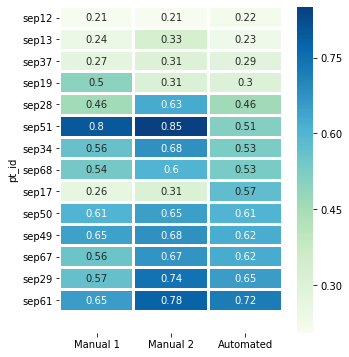

In [86]:
comparison_plots(auto_population='cd3+', 
                 auto_parent='lymphocytes', 
                 l_manual_col_name='% live Tcells from lympho', 
                 ylabel='% Live T cells',
                 manual_population='Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count',
                 manual_parent='Lymphocytes | Count')

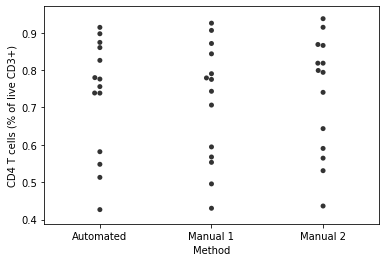

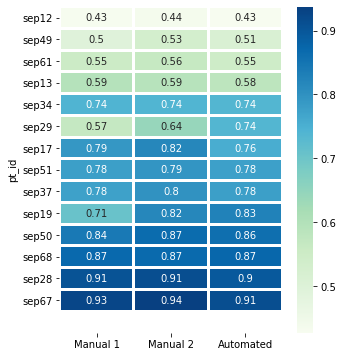

In [87]:
comparison_plots(auto_population='cd4', 
                 auto_parent='cd3+', 
                 l_manual_col_name='% CD4 T cells from live T cells', 
                 ylabel='CD4 T cells (% of live CD3+)',
                 manual_population='Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD4 | Count',
                 manual_parent='Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count')

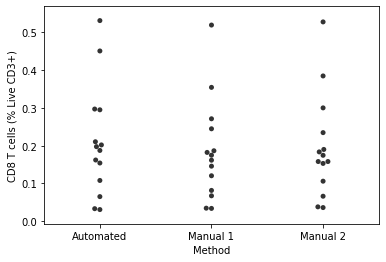

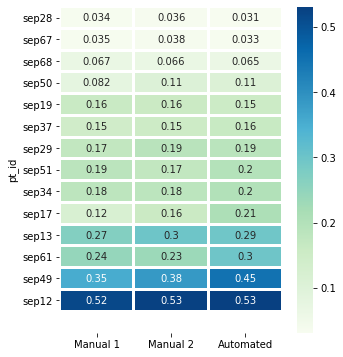

In [88]:
comparison_plots(auto_population='cd8', 
                 auto_parent='cd3+', 
                 l_manual_col_name='% CD8 T cells from live T cells', 
                 ylabel='CD8 T cells (% Live CD3+)',
                 manual_population='Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/Classic T cells/CD8 | Count',
                 manual_parent='Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count')

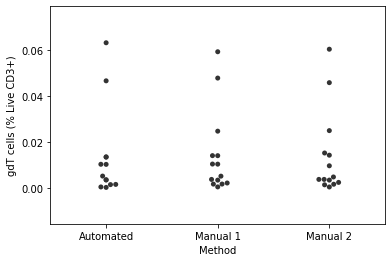

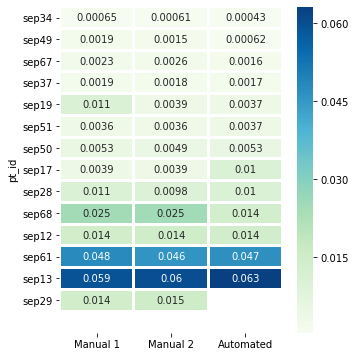

In [89]:
comparison_plots(auto_population='gdt', 
                 auto_parent='cd3+', 
                 l_manual_col_name='% Vd2+ GD T cells from live T cells', 
                 ylabel='gdT cells (% Live CD3+)',
                 manual_population='Lymphocytes/Single Cells/Single Cells/Live/CD3+/GDTs | Count',
                 manual_parent='Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count')

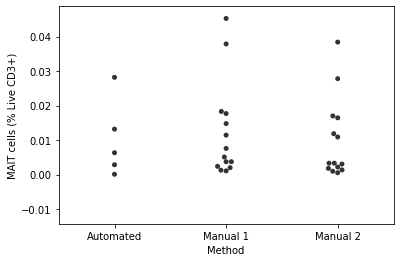

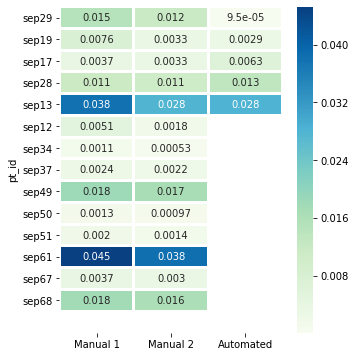

In [90]:
comparison_plots(auto_population='mait', 
                 auto_parent='cd3+', 
                 l_manual_col_name='% MAIT cells from live T cells', 
                 ylabel='MAIT cells (% Live CD3+)',
                 manual_population='Lymphocytes/Single Cells/Single Cells/Live/CD3+/NonGDTs/MAITs | Count',
                 manual_parent='Lymphocytes/Single Cells/Single Cells/Live/CD3+ | Count')

sep51 Lymphocyte failure

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c6c9e10>)

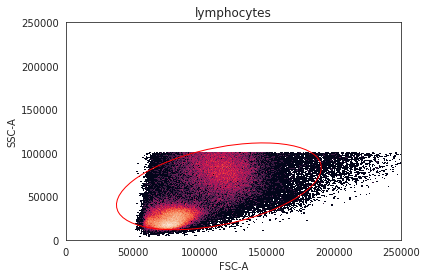

CD3 sep37, sep13, sep51, sep6, sep34, sep51

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c048da0>)

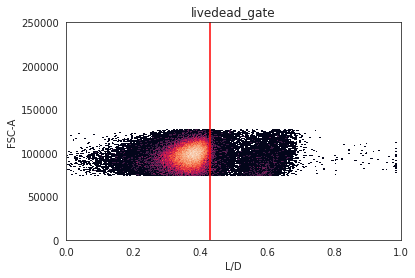

In [80]:
t_template = Template(experiment=t1_exp, sample_id='sep37')
t_template.plot_gate('livedead_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c0a8240>)

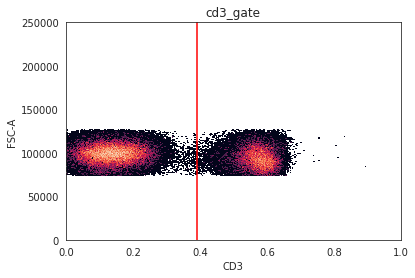

In [81]:
t_template.plot_gate('cd3_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f737e14a470>)

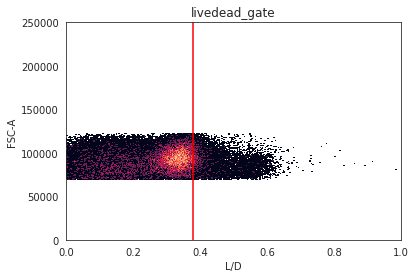

In [82]:
t_template = Template(experiment=t1_exp, sample_id='sep6')
t_template.plot_gate('livedead_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c2a9898>)

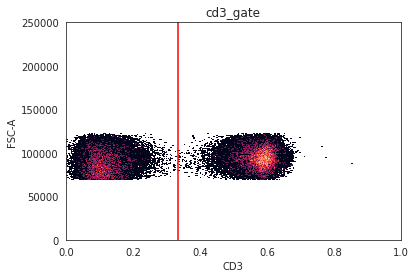

In [83]:
t_template.plot_gate('cd3_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c135390>)

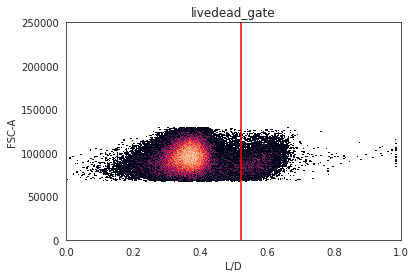

In [84]:
t_template = Template(experiment=t1_exp, sample_id='sep34')
t_template.plot_gate('livedead_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7394ccf518>)

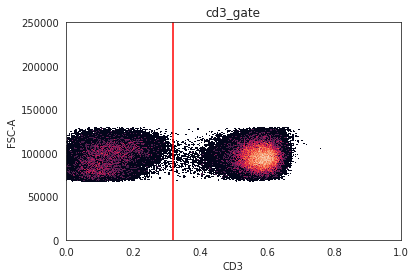

In [85]:
t_template.plot_gate('cd3_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7394d23320>)

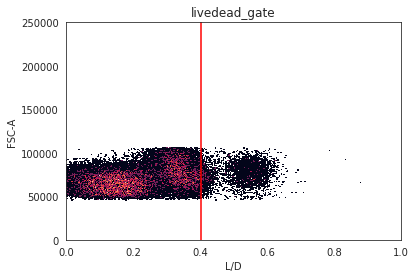

In [86]:
t_template = Template(experiment=t1_exp, sample_id='sep13')
t_template.plot_gate('livedead_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c6cfa58>)

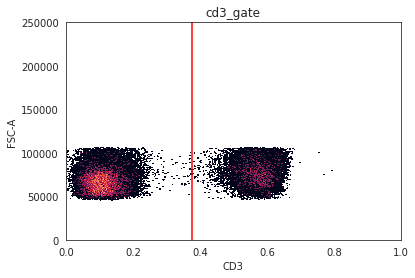

In [87]:
t_template.plot_gate('cd3_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c6cc320>)

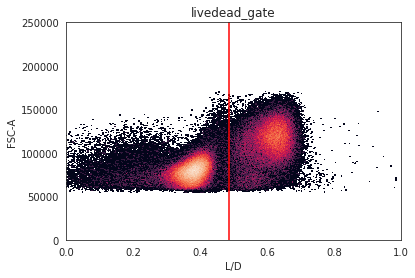

In [88]:
t_template = Template(experiment=t1_exp, sample_id='sep51')
t_template.plot_gate('livedead_gate')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f738c14a0b8>)

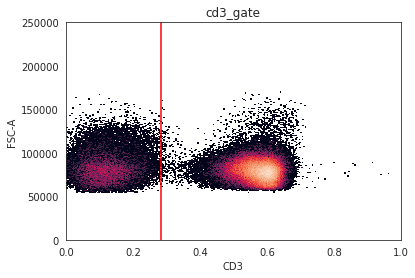

In [89]:
t_template.plot_gate('cd3_gate')

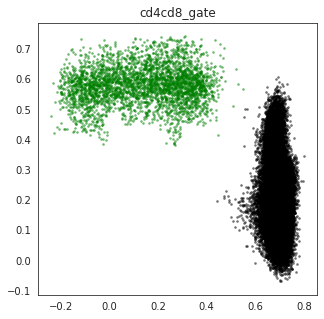

In [90]:
t_template = Template(experiment=t1_exp, sample_id='sep6')
t_template.plot_gate('cd4cd8_gate')

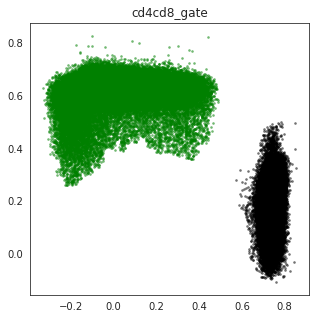

In [92]:
t_template = Template(experiment=t1_exp, sample_id='sep49')
t_template.plot_gate('cd4cd8_gate')

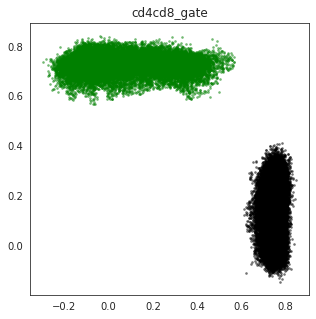

In [93]:
t_template = Template(experiment=t1_exp, sample_id='sep37')
t_template.plot_gate('cd4cd8_gate')

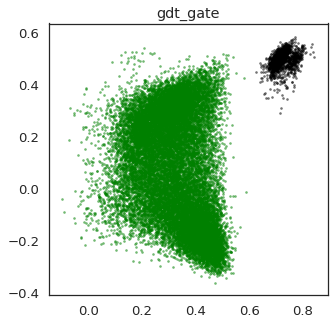

In [117]:
t_template = Template(experiment=t1_exp, sample_id='sep13')
t_template.plot_gate('gdt_gate')

In [118]:
t_template.id

'sep13'

In [119]:
import umap

In [120]:
cd3['label'] = 'None'

In [122]:
cd3.shape

(24229, 19)

In [124]:
cd3['label'] = 'None'

In [127]:
gdt = t_template.populations['gdt']['index']
mait = t_template.populations['mait']['index']
cd4 = t_template.populations['cd4']['index']
cd8 = t_template.populations['cd8']['index']

In [128]:
for name, idx in zip(['gdt', 'mait', 'cd4', 'cd8'], [gdt, mait, cd4, cd8]):
    cd3['label'] = cd3['label'].mask(cd3.index.isin(idx), name)

In [141]:
features = [c for c in cd3.columns if c not in ['Time', 'label', 'umap0', 'umap1']]
features = [f for f in features if f.find('SSC') == -1 and f.find('FSC') == -1]

In [142]:
fit = umap.UMAP()

In [143]:
embeddings = fit.fit_transform(cd3[features])

In [144]:
cd3['umap0'] = embeddings[:, 0]
cd3['umap1'] = embeddings[:, 1]

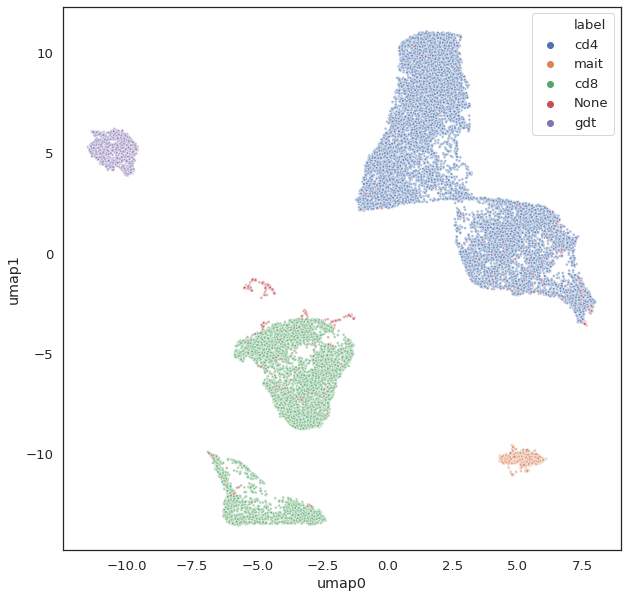

In [145]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=cd3, x='umap0', y='umap1', hue='label', s=8, alpha=0.5, ax=ax)

In [154]:
cd3.CD161.values.tolist()

[0.4111255127461622,
 0.6079239115970816,
 0.12373179347089919,
 0.6552126319979842,
 0.06656208022876495,
 0.27101773871498736,
 0.28999898561207615,
 0.2761561200880444,
 0.33030085280871757,
 -0.005929882127800823,
 0.006466819677845598,
 0.3049373829341555,
 0.25368153105658886,
 0.2831298901114028,
 0.5082305720407778,
 0.31348072081188605,
 0.4736062360542715,
 0.2736237411094687,
 -0.12594134696058795,
 0.2954583594732173,
 0.4241610921251259,
 0.42787099465855577,
 0.47388493876795695,
 0.4821436995053299,
 0.4080684266370512,
 0.0787850397044608,
 0.4439130391793343,
 0.21528573639347637,
 0.3769022495747753,
 0.4847585199058357,
 0.3443735743152227,
 0.18737297973119274,
 0.15684368161436144,
 0.4027909188628913,
 0.3068965038329558,
 0.014647739076028204,
 0.06707371222750944,
 0.14705718243345547,
 0.7008282638463923,
 0.16990718501830201,
 0.35905868678139313,
 0.39369392067791076,
 0.19062374195310802,
 0.5058928706231085,
 -0.01227209798315032,
 0.23575113843921833,
 0.2